#### load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flopy
from flopy.plot import styles
import os
import shutil

In [2]:
import pandas as pd

#### specify folder location of modflow 6 model files created by converter, and new folder to place a copy of the files that we will use here

In [3]:
orig_dir = os.path.join("data", "mumodel_mf6")
tpl_dir = os.path.join("data", "mumodel_tpl")
if os.path.exists(tpl_dir):
    shutil.rmtree(tpl_dir)
shutil.copytree(orig_dir, tpl_dir)

'data\\mumodel_tpl'

#### instantiate a flopy model object from the files copied to the new folder

In [4]:
name = "mumodel"
exe_name = "mf6"
sim = flopy.mf6.MFSimulation.load(sim_ws=tpl_dir)
m = sim.get_model(name)
mg = m.modelgrid

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package chd...
  loading solution package mumodel...


#### specify a coordinate refernce system for the model using the modelgrid object

In [5]:
mg.set_coord_info(crs="epsg:26912")

In [6]:
mg

xll:0.0; yll:0.0; rotation:0.0; crs:EPSG:26912; units:undefined; lenuni:0

## Create an Observation Package to track simulated heads at two locations: (row 11, column 5), and (row 5, column 5)

In [7]:
flopy.mf6.ModflowUtlobs(m, continuous={"hds.csv": [("hds001_010_004", "HEAD", (0, 10, 4)), ("hds001_004_004", "HEAD", (0, 4, 4))]})

package_name = obs_0
filename = mumodel.obs
package_type = obs
model_or_simulation_package = model
model_name = mumodel

Block continuous
--------------------
continuous
{internal}
(rec.array([('hds001_010_004', 'HEAD', (0, 10, 4), None),
           ('hds001_004_004', 'HEAD', (0, 4, 4), None)],
          dtype=[('obsname', 'O'), ('obstype', 'O'), ('id', 'O'), ('id2', 'O')]))



#### write the MODFLOW 6 model input files and run the model

In [8]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package mumodel...
  writing model mumodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
    writing package wel-1...
    writing package rch-1...
    writing package chd-from-ibound...
    writing package obs_0...


In [9]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\..\..\..\..\..\A\envs\pyclass\Scripts\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither

(True, [])

#### instantiate an object of the saved head outputs (here we are just using a predefined flopy method that finds the binary output file specified in the NAM file and returns the head values)

In [10]:
hds = m.output.head()

#### the get_alldata() method returns a 4 dimensional numpy array (time, layer, row, column) of all saved head values

#### the numpy array object has an associated method that will convert the array into a 1D array of values that can be fed to a histogram plot

(array([ 3474.,     0.,  3482.,    55.,  3505.,  3468.,  3386.,  3474.,
         3474., 12159.]),
 array([1000.        , 1001.09275262, 1002.18550524, 1003.27825786,
        1004.37101048, 1005.4637631 , 1006.55651572, 1007.64926834,
        1008.74202096, 1009.83477359, 1010.92752621]),
 <BarContainer object of 10 artists>)

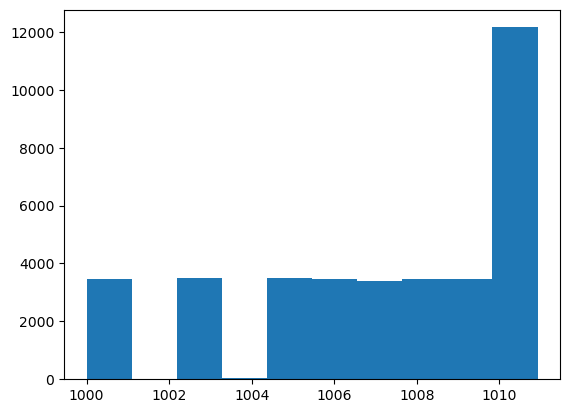

In [11]:
plt.hist(hds.get_alldata().ravel())

#### create a FOR LOOP to cycle through the timesteps for which heads are saved in the head output file and plot a 2D array for each of the simulated time step outputs

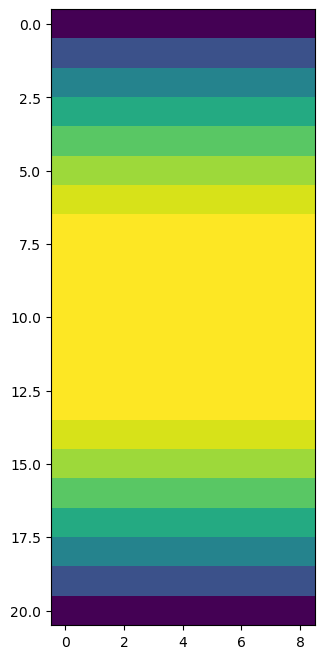

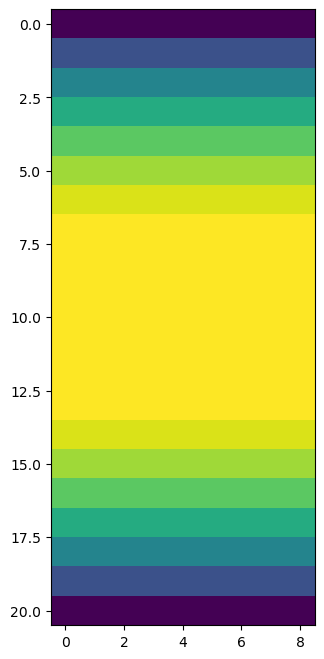

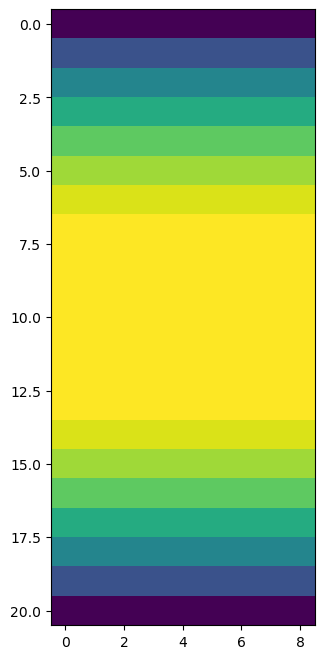

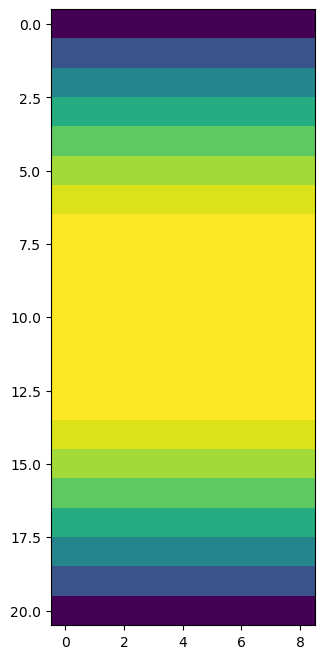

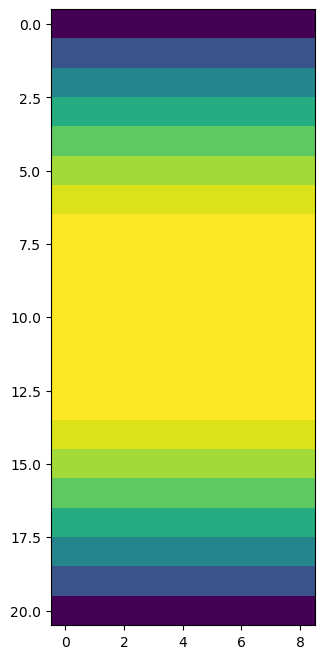

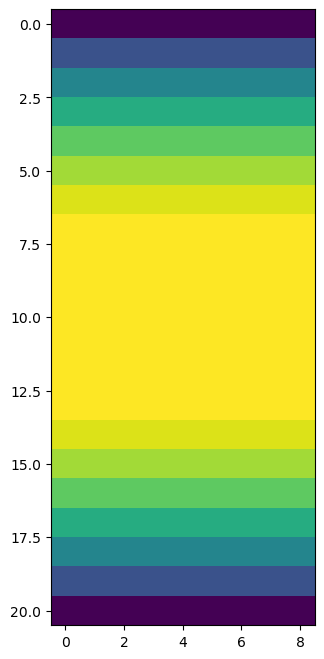

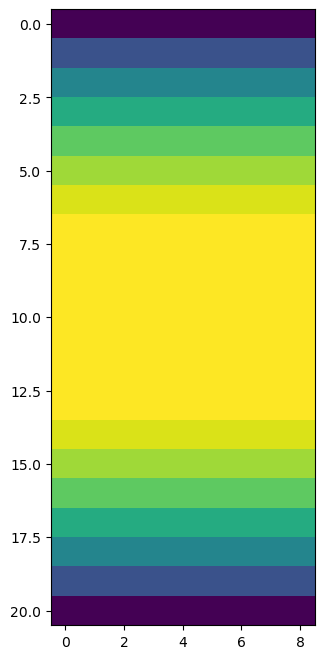

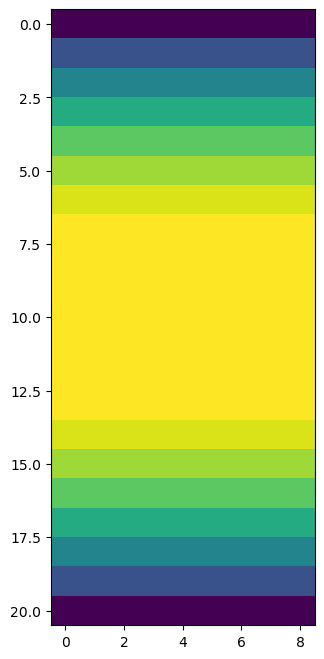

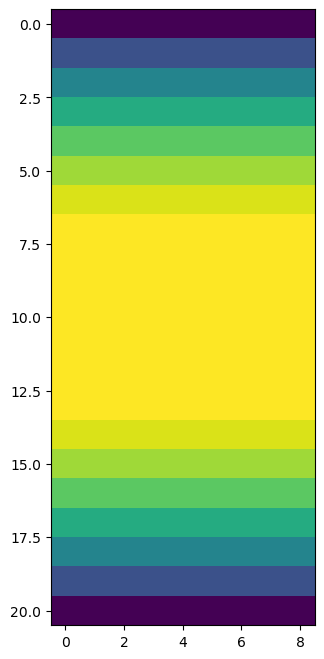

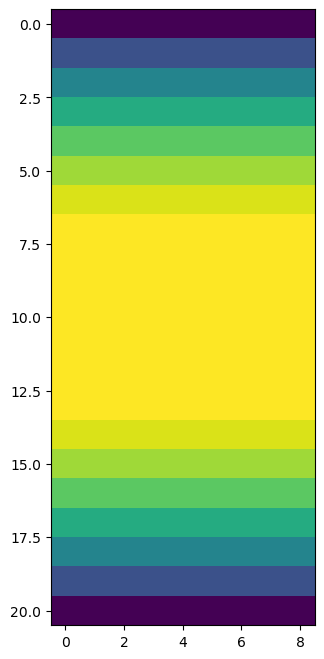

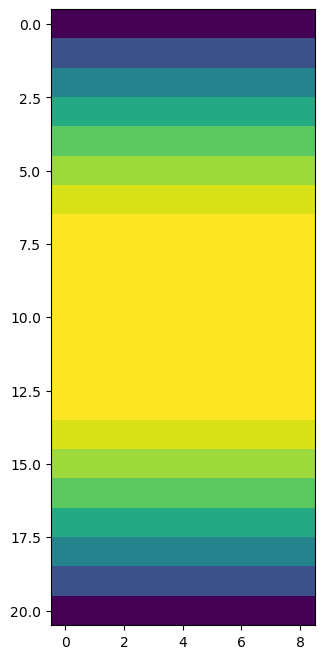

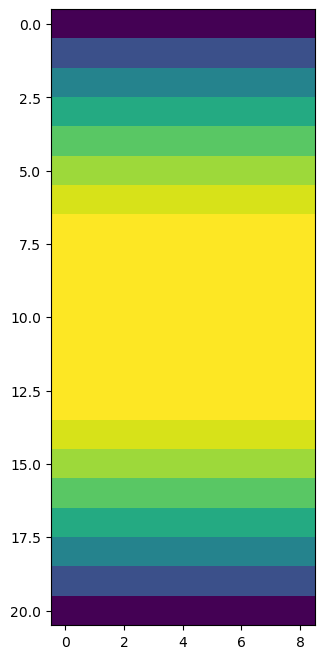

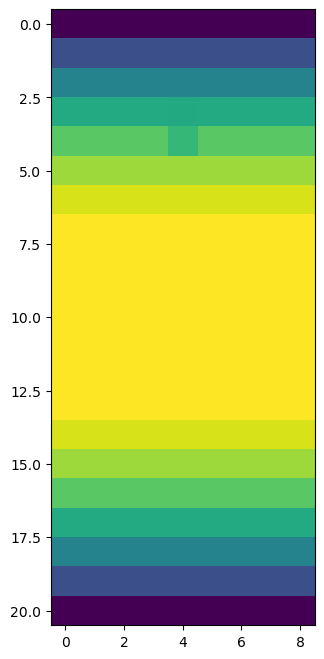

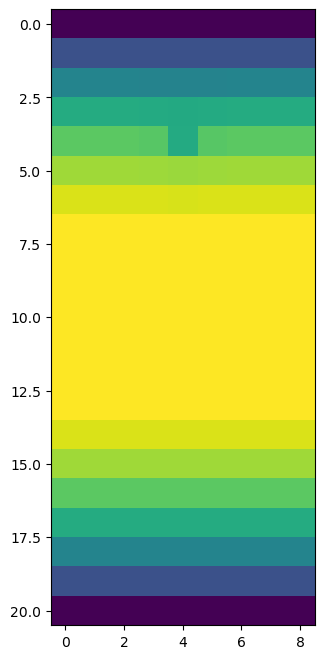

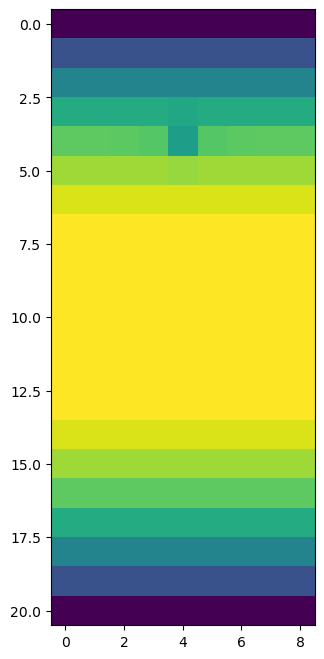

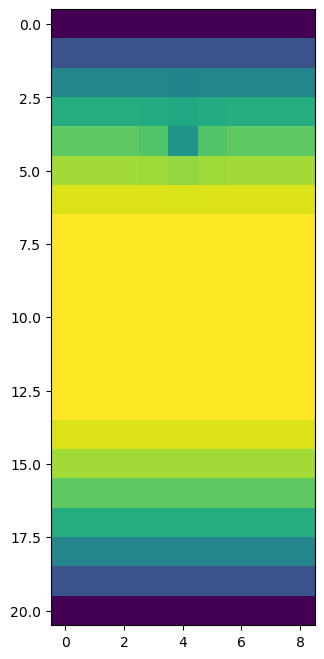

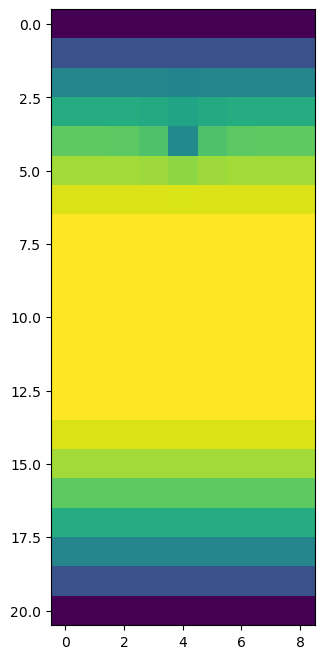

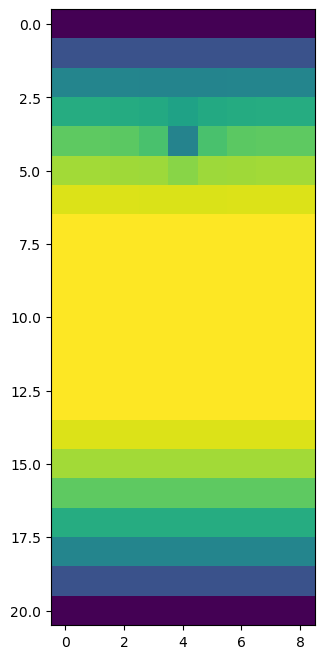

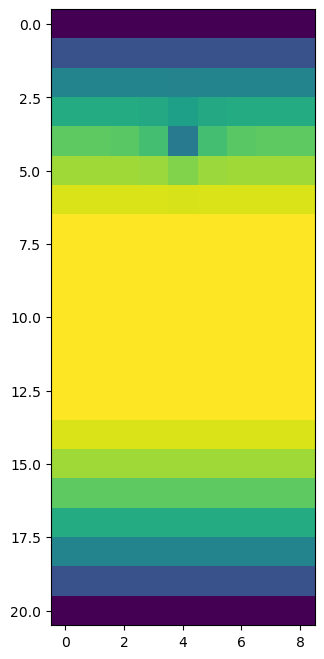

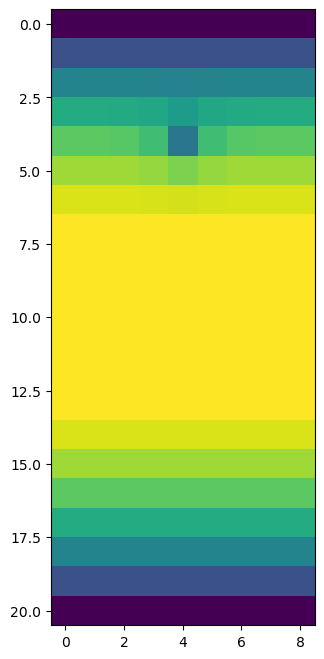

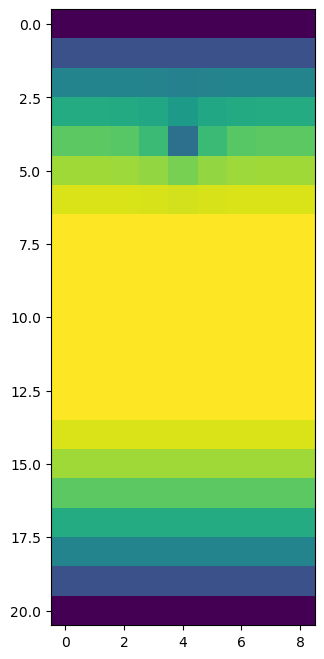

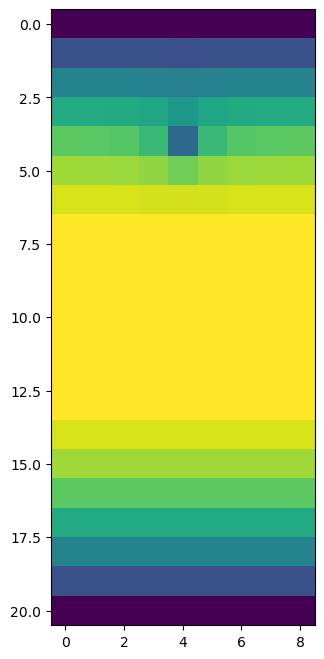

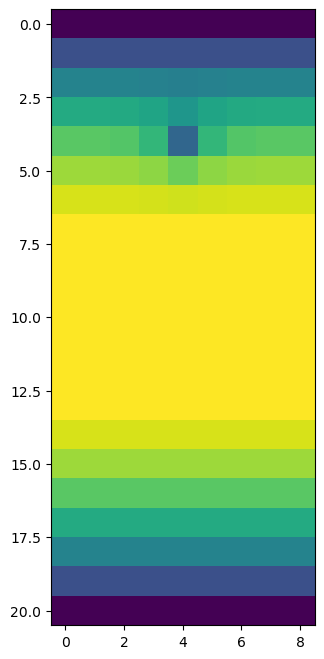

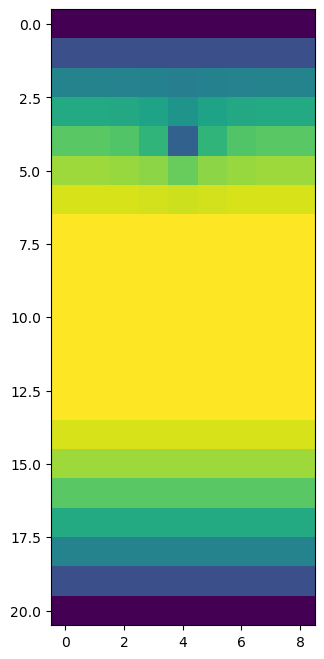

In [12]:
for i, (ts, sp) in enumerate(hds.get_kstpkper()):
    if ts == 7:
        f, ax = plt.subplots(1,1,figsize=(4,8), dpi=100)
        ax.imshow(hds.get_data(kstpkper=(ts, sp))[0], vmin=1000, vmax=1010)

#### instantiate a cell-by-cell budget output object

In [13]:
cbc = m.output.budget()

#### grab the info saved in the CBC output for the WEL and RCH packages

In [14]:
wel = cbc.get_data(text='wel', full3D=True)[-1].sum(axis=0)

In [15]:
rch = cbc.get_data(text='rch', full3D=True)

## create a fancy plot of simulated head contours

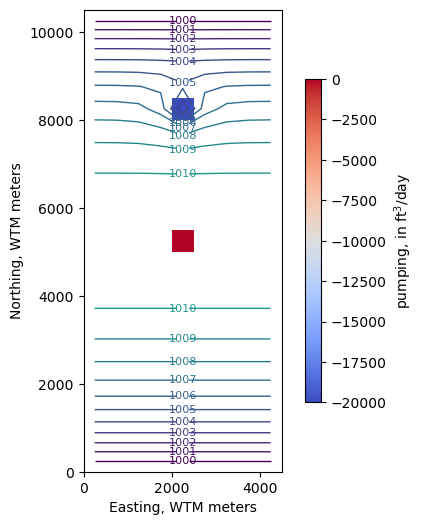

In [16]:
levels=np.arange(1000, 1020, 1)
wt = hds.get_data()
fig, ax = plt.subplots(figsize=(6, 6))
pmv = flopy.plot.PlotMapView(m, ax=ax)
ctr = pmv.contour_array(wt, levels=levels, 
                        linewidths=1, cmap='viridis')
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
vmin, vmax = -20000, 0
im = pmv.plot_array(wel, cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='pumping, in ft$^3$/day')
ax.set_ylabel("Northing, WTM meters")
ax.set_xlabel("Easting, WTM meters")
ax.set_aspect(1)

#### pull a time-series of simulated heads at a specific model cell and plot

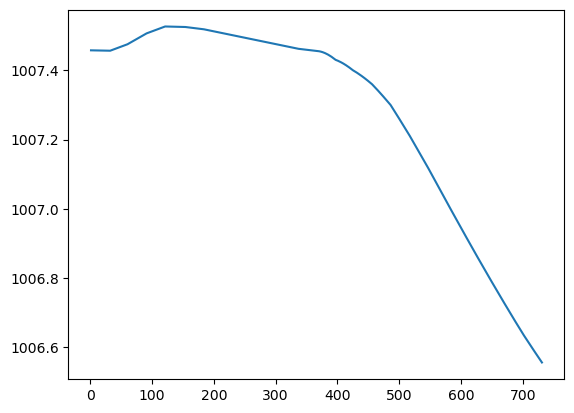

In [17]:
ts = hds.get_ts((0, 4, 3))
plt.plot(ts[:, 0], ts[:, 1])

## Try modifying a model property and rewrite the input files and run the model

#### the model object "m" has a child object "npf" which has an attribute "k" which has an attribute "data" which is a 3D array of horizontal hydraulic conductivity in each model cell

In [18]:
m.npf.k.data

array([[[50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [5

#### change the hk value

In [20]:
m.npf.k = 25.

#### rewrite the NPF package input file

In [21]:
m.npf.write()

#### rerun the simulation

In [22]:
sim.run_simulation(silent=True)

(True, [])

#### grab the new output and compare to the original output

(1000.0, 1020.0)

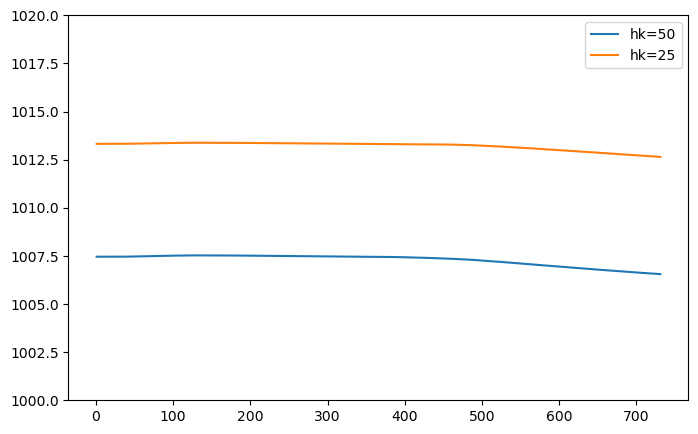

In [23]:
hds = m.output.head()
ts1 = hds.get_ts((0, 4, 3))
f, ax = plt.subplots(1,1,figsize=(8,5), dpi=100)
ax.plot(ts[:, 0], ts[:, 1], label="hk=50")
ax.plot(ts1[:, 0], ts1[:, 1], label="hk=25")
ax.legend(loc=1)
ax.set_ylim([1000, 1020])

## write a loop to try lots of values

#### save a timeseries of simulated head values from each to compare

In [24]:
hdsdict = {}
for kval in [25., 32., 39., 45., 50., 60., 70., 80., 100.]:
    m.npf.k = kval
    m.npf.write()
    sim.run_simulation(silent=True)
    hds = m.output.head()
    ts = hds.get_ts((0, 4, 3))
    hdsdict["hk{0}".format(kval)] = ts[:, 1]

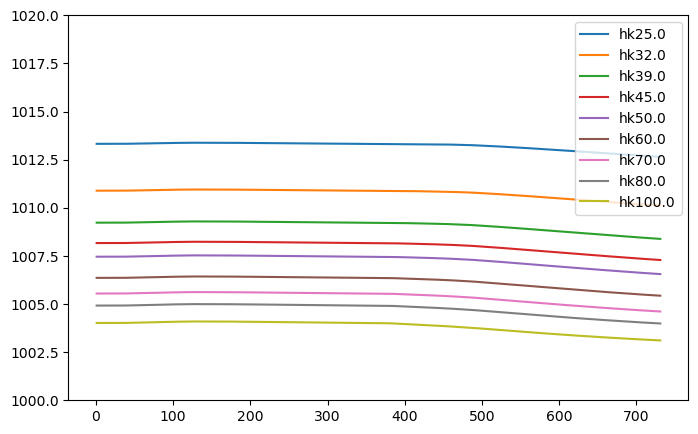

In [25]:
f, ax = plt.subplots(1,1,figsize=(8,5), dpi=100)
for hkval, ts in hdsdict.items():
    ax.plot(hds.get_times(), ts, label=hkval)
    ax.legend(loc=1)
    ax.set_ylim([1000, 1020])

#### reset to original value

In [26]:
m.npf.k = 50.

In [27]:
m.npf.write()

## now try the same heuristic exercise with recharge

In [31]:
spd = m.rch.recharge.get_data()
hdsdict1 = {}

for rfact in [.5, .62, .75, .87, 1., 1.25, 1.5, 1.75, 2.0]:
    print("running model with recharge modified by factor of {0}".format(rfact))
    spdi = {}
    for k, v in spd.items():
        if not v is None:
            spdi[k] = v * rfact
    m.rch.recharge.set_data(spdi)
    m.rch.write()
    sim.run_simulation(silent=True)
    hds = m.output.head()
    ts = hds.get_ts((0, 4, 3))
    hdsdict1["rch{0}".format(rfact)] = ts[:, 1]

# reset rch to original value
m.rch.recharge.set_data(spd)

running model with recharge modified by factor of 0.5
running model with recharge modified by factor of 0.62
running model with recharge modified by factor of 0.75
running model with recharge modified by factor of 0.87
running model with recharge modified by factor of 1.0
running model with recharge modified by factor of 1.25
running model with recharge modified by factor of 1.5
running model with recharge modified by factor of 1.75
running model with recharge modified by factor of 2.0


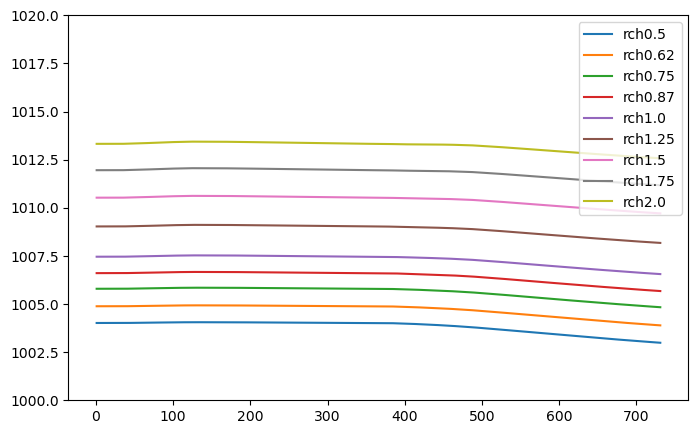

In [32]:
f, ax = plt.subplots(1,1,figsize=(8,5), dpi=100)
for rchval, ts in hdsdict1.items():
    ax.plot(hds.get_times(), ts, label=rchval)
    ax.legend(loc=1)
    ax.set_ylim([1000, 1020])

#### water use input (via WEL package) is a little more complicated than HK and RCH. Need to create a template object of the stress period data that we can modify and specify for each model re-write

In [37]:
wspd = m.wel.stress_period_data.get_data()

In [38]:
wspd

{0: rec.array([((0, 4, 4), 0., 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)],
           dtype=[('cellid', 'O'), ('q', '<f8'), ('iface', '<f8')]),
 13: rec.array([((0, 4, 4), -20000., 0.), ((0, 10, 4),      0., 0.),
            ((0, 4, 4),      0., 0.)],
           dtype=[('cellid', 'O'), ('q', '<f8'), ('iface', '<f8')])}

In [39]:
q = -20000.
qfac = 1.
tpl_spd = {0: [((0, 4, 4), 0., 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)],
           13:[((0, 4, 4), q * qfac, 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)]}

In [40]:
tpl_spd

{0: [((0, 4, 4), 0.0, 0.0), ((0, 10, 4), 0.0, 0.0), ((0, 4, 4), 0.0, 0.0)],
 13: [((0, 4, 4), -20000.0, 0.0),
  ((0, 10, 4), 0.0, 0.0),
  ((0, 4, 4), 0.0, 0.0)]}

In [41]:
hdsdict2 = {}
for qfac in [.5, .62, .75, .87, 1., 1.25, 1.5, 1.75, 2.0]:
    print("running model with pumping modified by factor of {0}".format(qfac))
    tpl_spd = {0: [((0, 4, 4), 0., 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)],
           13:[((0, 4, 4), q * qfac, 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)]}
    m.wel.stress_period_data.set_data(tpl_spd)
    m.wel.write()
    sim.run_simulation(silent=True)
    hds = m.output.head()
    ts = hds.get_ts((0, 4, 3))
    hdsdict2["wel{0}".format(qfac)] = ts[:, 1]

running model with pumping modified by factor of 0.5
running model with pumping modified by factor of 0.62
running model with pumping modified by factor of 0.75
running model with pumping modified by factor of 0.87
running model with pumping modified by factor of 1.0
running model with pumping modified by factor of 1.25
running model with pumping modified by factor of 1.5
running model with pumping modified by factor of 1.75
running model with pumping modified by factor of 2.0


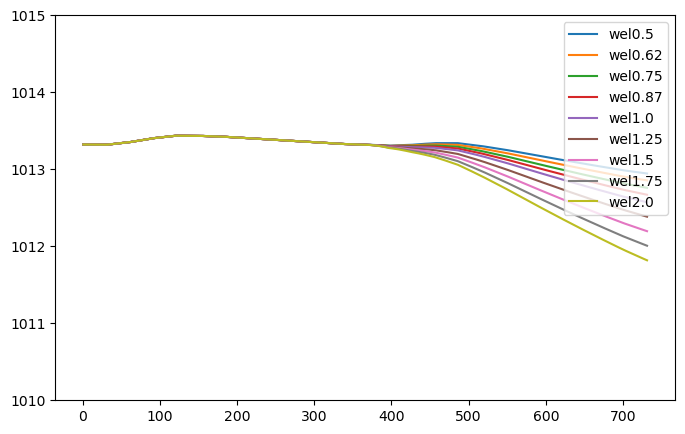

In [42]:
f, ax = plt.subplots(1,1,figsize=(8,5), dpi=100)
for rchval, ts in hdsdict2.items():
    ax.plot(hds.get_times(), ts, label=rchval)
    ax.legend(loc=1)
    ax.set_ylim([1010, 1015])

#### reset to original pumping rate

In [43]:
qfac = 1.0
tpl_spd = {0: [((0, 4, 4), 0., 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)],
       13:[((0, 4, 4), q * qfac, 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)]}
m.wel.stress_period_data.set_data(tpl_spd)
m.wel.write()
sim.run_simulation(silent=True)
hds = m.output.head()

In [44]:
hds = m.output.head()

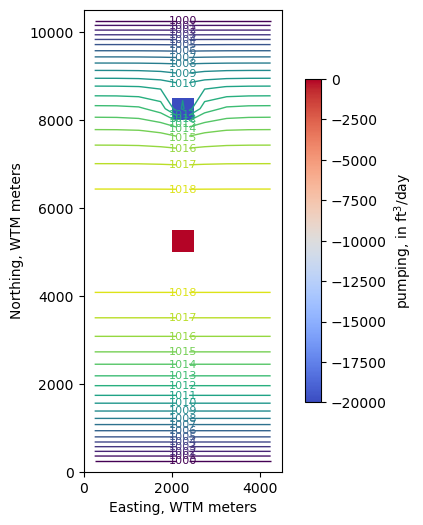

In [45]:
levels=np.arange(1000, 1020, 1)
wt = hds.get_data()
fig, ax = plt.subplots(figsize=(6, 6))
pmv = flopy.plot.PlotMapView(m, ax=ax)
ctr = pmv.contour_array(wt, levels=levels, 
                        linewidths=1, cmap='viridis')
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
vmin, vmax = -20000, 0
im = pmv.plot_array(wel, cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='pumping, in ft$^3$/day')
ax.set_ylabel("Northing, WTM meters")
ax.set_xlabel("Easting, WTM meters")
ax.set_aspect(1)

In [43]:
m.set_all_data_external()
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package mumodel...
  writing model mumodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
    writing package wel-1...
    writing package rch-1...
    writing package chd-from-ibound...
    writing package obs_0...


In [42]:
import pyemu

C:\A\envs\pyclass\Lib\site-packages\pyemu\pst\pst_handler.py:15: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


In [44]:
pst_dir = os.path.join("data", "mumodel_pst")

In [45]:
pf = pyemu.utils.PstFrom(original_d=tpl_dir, new_d=pst_dir, remove_existing=True, spatial_reference=mg)

2024-03-27 08:48:28.133115 starting: opening PstFrom.log for logging
2024-03-27 08:48:28.133115 starting PstFrom process
2024-03-27 08:48:28.133115 starting: setting up dirs
2024-03-27 08:48:28.133115 starting: removing existing new_d 'data\mumodel_pst'
2024-03-27 08:48:28.157203 finished: removing existing new_d 'data\mumodel_pst' took: 0:00:00.024088
2024-03-27 08:48:28.157203 starting: copying original_d 'data\mumodel_tpl' to new_d 'data\mumodel_pst'
2024-03-27 08:48:28.305320 finished: copying original_d 'data\mumodel_tpl' to new_d 'data\mumodel_pst' took: 0:00:00.148117
2024-03-27 08:48:28.306314 finished: setting up dirs took: 0:00:00.173199


In [46]:
os.listdir(pst_dir)

['hds.csv',
 'mfsim.lst',
 'mfsim.nam',
 'mult',
 'mumodel.dis',
 'mumodel.dis.grb',
 'mumodel.dis_botm.txt',
 'mumodel.dis_delc.txt',
 'mumodel.dis_delr.txt',
 'mumodel.dis_top.txt',
 'mumodel.ib.chd.obs',
 'mumodel.ib.ibound.chd',
 'mumodel.ib.ibound.chd_stress_period_data_1.txt',
 'mumodel.ic',
 'mumodel.ic_strt.txt',
 'mumodel.ims',
 'mumodel.lst',
 'mumodel.nam',
 'mumodel.npf',
 'mumodel.npf_icelltype.txt',
 'mumodel.npf_k.txt',
 'mumodel.obs',
 'mumodel.obs_continuous_hds.csv.txt',
 'mumodel.oc',
 'mumodel.rch',
 'mumodel.rch_recharge_1.txt',
 'mumodel.rch_recharge_13.txt',
 'mumodel.rch_recharge_14.txt',
 'mumodel.rch_recharge_15.txt',
 'mumodel.rch_recharge_16.txt',
 'mumodel.rch_recharge_17.txt',
 'mumodel.rch_recharge_18.txt',
 'mumodel.rch_recharge_19.txt',
 'mumodel.rch_recharge_2.txt',
 'mumodel.rch_recharge_20.txt',
 'mumodel.rch_recharge_25.txt',
 'mumodel.rch_recharge_3.txt',
 'mumodel.rch_recharge_4.txt',
 'mumodel.rch_recharge_5.txt',
 'mumodel.rch_recharge_6.txt',
 

In [47]:
vr_pp = pyemu.utils.geostats.ExpVario(a=2000, contribution=1.0)
vr_gr = pyemu.utils.geostats.ExpVario(a=500, contribution=1.0)

In [48]:
gs_pp = pyemu.utils.geostats.GeoStruct(variograms=vr_pp, transform="log")
gs_gr = pyemu.utils.geostats.GeoStruct(variograms=vr_gr, transform="log")

In [49]:
property_dict = {"npf_k": (10., 200.), "sto_sy": (0.05, 0.35)}

for prop, (lb, ub) in property_dict.items():
    filenames=['mumodel.{0}.txt'.format(prop)]
    pf.add_parameters(filenames, par_type="constant", upper_bound=2., lower_bound=0.5,
                      par_name_base=prop, pargp=prop.split("_")[0] + "_cn", ult_ubound=ub, ult_lbound=lb)
    pf.add_parameters(filenames, par_type="pilotpoint", upper_bound=2., lower_bound=0.5,
                      par_name_base=prop, pargp=prop.split("_")[0] + "_pp", pp_space=4, ult_ubound=ub, ult_lbound=lb, geostruct=gs_pp)
    pf.add_parameters(filenames, par_type="grid", upper_bound=2., lower_bound=0.5,
                      par_name_base=prop, pargp=prop.split("_")[0] + "_gr", ult_ubound=ub, ult_lbound=lb, geostruct=gs_gr)

2024-03-27 08:48:28.338856 transform was not passed, setting default tranform to 'log'
2024-03-27 08:48:28.338856 starting: adding constant type m style parameters for file(s) ['mumodel.npf_k.txt']
2024-03-27 08:48:28.339866 starting: loading array data\mumodel_pst\mumodel.npf_k.txt
2024-03-27 08:48:28.341010 finished: loading array data\mumodel_pst\mumodel.npf_k.txt took: 0:00:00.001144
2024-03-27 08:48:28.341010 loaded array 'data\mumodel_tpl\mumodel.npf_k.txt' of shape (21, 9)
2024-03-27 08:48:28.342090 starting: writing array-style template file 'data\mumodel_pst\npf_k_inst0_constant.csv.tpl'
2024-03-27 08:48:28.342090 starting: writing template file data\mumodel_pst\npf_k_inst0_constant.csv.tpl for ['npf_k_inst:0']
2024-03-27 08:48:28.344562 finished: writing template file data\mumodel_pst\npf_k_inst0_constant.csv.tpl for ['npf_k_inst:0'] took: 0:00:00.002472
2024-03-27 08:48:28.344562 starting: writing array-based template file 'data\mumodel_pst\npf_k_inst0_constant.csv.tpl'
2024

In [50]:
filenames=[x for x in os.listdir(pst_dir) if x.startswith("mumodel.rch_recharge_")]

pf.add_parameters(filenames, par_type="constant", upper_bound=1.25, lower_bound=0.75,
                  par_name_base='rch_r', pargp="rch_cn")
pf.add_parameters(filenames, par_type="pilotpoint", upper_bound=1.25, lower_bound=0.75,
                  par_name_base='rch_r', pargp="rch_pp", pp_space=4, geostruct=gs_pp)

2024-03-27 08:48:32.198451 transform was not passed, setting default tranform to 'log'
2024-03-27 08:48:32.198451 starting: adding constant type m style parameters for file(s) ['mumodel.rch_recharge_1.txt', 'mumodel.rch_recharge_13.txt', 'mumodel.rch_recharge_14.txt', 'mumodel.rch_recharge_15.txt', 'mumodel.rch_recharge_16.txt', 'mumodel.rch_recharge_17.txt', 'mumodel.rch_recharge_18.txt', 'mumodel.rch_recharge_19.txt', 'mumodel.rch_recharge_2.txt', 'mumodel.rch_recharge_20.txt', 'mumodel.rch_recharge_25.txt', 'mumodel.rch_recharge_3.txt', 'mumodel.rch_recharge_4.txt', 'mumodel.rch_recharge_5.txt', 'mumodel.rch_recharge_6.txt', 'mumodel.rch_recharge_7.txt', 'mumodel.rch_recharge_8.txt']
2024-03-27 08:48:32.198451 WARNING: Discrepancy between number of filenames (17) and number of formatter strings (1). Will repeat first (free)
2024-03-27 08:48:32.199457 starting: loading array data\mumodel_pst\mumodel.rch_recharge_1.txt
2024-03-27 08:48:32.200760 finished: loading array data\mumodel_ps

C:\A\envs\pyclass\Lib\site-packages\pyemu\logger.py:100: PyemuWarning: 2024-03-27 08:48:32.198451 WARNING: Discrepancy between number of filenames (17) and number of formatter strings (1). Will repeat first (free)

C:\A\envs\pyclass\Lib\site-packages\pyemu\logger.py:100: PyemuWarning: 2024-03-27 08:48:32.242385 WARNING: Discrepancy between number of filenames (17) and number of formatter strings (1). Will repeat first (free)



,name,x,y,zone,parval1,k,i,j,parnme,tpl,...,pp_filename,pargp,dercom,offset,parchglim,parlbnd,partrans,parubnd,scale,partype
parnme,,,,,,,,,,,,,,,,,,,,,
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:2_zone:1,pp_0000,1250.0,9250.0,1,1.0,0,2,2,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:2_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:2_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:6_zone:1,pp_0001,3250.0,9250.0,1,1.0,0,2,6,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:6_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:6_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:2_zone:1,pp_0002,1250.0,7250.0,1,1.0,0,6,2,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:2_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:2_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:6_zone:1,pp_0003,3250.0,7250.0,1,1.0,0,6,6,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:6_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:6_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:2_zone:1,pp_0004,1250.0,5250.0,1,1.0,0,10,2,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:2_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:2_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:6_zone:1,pp_0005,3250.0,5250.0,1,1.0,0,10,6,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:6_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:6_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:2_zone:1,pp_0006,1250.0,3250.0,1,1.0,0,14,2,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:2_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:2_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:6_zone:1,pp_0007,3250.0,3250.0,1,1.0,0,14,6,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:6_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:6_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:18_j:2_zone:1,pp_0008,1250.0,1250.0,1,1.0,0,18,2,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:18_j:2_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:18_j:2_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint


#### add observations to track

In [51]:
hds_df = pf.add_observations(filename="hds.csv", index_cols=0, use_cols=[1, 2], obsgp="hds")

2024-03-27 08:48:32.313962 starting: adding observations from output file hds.csv
2024-03-27 08:48:32.313962 starting: adding observations from tabular output file '['hds.csv']'
2024-03-27 08:48:32.313962 starting: reading list-style file: data\mumodel_pst\hds.csv
2024-03-27 08:48:32.324424 finished: reading list-style file: data\mumodel_pst\hds.csv took: 0:00:00.010462
2024-03-27 08:48:32.328420 starting: building insfile for tabular output file hds.csv
2024-03-27 08:48:32.333547 finished: building insfile for tabular output file hds.csv took: 0:00:00.005127
2024-03-27 08:48:32.333547 starting: adding observation from instruction file 'data\mumodel_pst\hds.csv.ins'
2024-03-27 08:48:32.347591 finished: adding observation from instruction file 'data\mumodel_pst\hds.csv.ins' took: 0:00:00.014044
2024-03-27 08:48:32.349610 finished: adding observations from tabular output file '['hds.csv']' took: 0:00:00.035648
2024-03-27 08:48:32.349610 finished: adding observations from output file hds.

C:\A\envs\pyclass\Lib\site-packages\pyemu\utils\pst_from.py:1484: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
C:\A\envs\pyclass\Lib\site-packages\pyemu\utils\pst_from.py:1502: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead


In [52]:
hds_df.loc[:, "time"] = hds_df.loc[:, "obsnme"].apply(lambda x: float(x.split(":")[-1]))

In [53]:
hds_df.loc[:, "datetime"] = hds_df.loc[:, "time"].apply(lambda x: pd.to_datetime("20200101") + np.timedelta64(int(x), "D"))

In [54]:
hds_df.loc[:, "obgnme"] = hds_df.loc[:, "obsnme"].apply(lambda x: x.split("usecol:")[-1].split("_time")[0])

In [55]:
hds_df.loc[hds_df["datetime"].apply(lambda x: x.year>2020), "weight"] = 0.

In [56]:
hds_df.loc[:, "datetime1"] = hds_df.loc[:, "datetime"].apply(lambda x: x.strftime("%Y%m%d"))

In [57]:
hds_df.drop(["time", "datetime"], axis=1, inplace=True)

In [58]:
hds_df.rename(columns={"datetime1":"datetime"}, inplace=True)

In [59]:
hds_df.sort_values("obsnme", inplace=True)

In [60]:
pf.mod_sys_cmds.append("mf6")

In [61]:
pst = pf.build_pst(os.path.join(pst_dir, "mumodel.pst"), version=2)

noptmax:0, npar_adj:411, nnz_obs:192
2024-03-27 08:48:32.602129 forward_run line:pyemu.os_utils.run(r'mf6')



C:\A\envs\pyclass\Lib\site-packages\pyemu\pst\pst_handler.py:1362: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\A\envs\pyclass\Lib\site-packages\pyemu\pst\pst_handler.py:3866: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'np

In [62]:
pst.observation_data = hds_df

In [63]:
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,pname,inst,ptype,pstyle,i,j,zone,x,y
pname:npf_k_inst:0_ptype:cn_pstyle:m,pname:npf_k_inst:0_ptype:cn_pstyle:m,log,factor,1.0,0.50,2.00,npf_cn,1.0,0.0,1,npf,0,cn,m,NaN,NaN,NaN,NaN,NaN
pname:npf_k_inst:1_ptype:pp_pstyle:m_i:2_j:2_zone:1,pname:npf_k_inst:1_ptype:pp_pstyle:m_i:2_j:2_zone:1,log,factor,1.0,0.50,2.00,npf_pp,1.0,0.0,1,npf,1,pp,m,2,2,1,NaN,NaN
pname:npf_k_inst:1_ptype:pp_pstyle:m_i:2_j:6_zone:1,pname:npf_k_inst:1_ptype:pp_pstyle:m_i:2_j:6_zone:1,log,factor,1.0,0.50,2.00,npf_pp,1.0,0.0,1,npf,1,pp,m,2,6,1,NaN,NaN
pname:npf_k_inst:1_ptype:pp_pstyle:m_i:6_j:2_zone:1,pname:npf_k_inst:1_ptype:pp_pstyle:m_i:6_j:2_zone:1,log,factor,1.0,0.50,2.00,npf_pp,1.0,0.0,1,npf,1,pp,m,6,2,1,NaN,NaN
pname:npf_k_inst:1_ptype:pp_pstyle:m_i:6_j:6_zone:1,pname:npf_k_inst:1_ptype:pp_pstyle:m_i:6_j:6_zone:1,log,factor,1.0,0.50,2.00,npf_pp,1.0,0.0,1,npf,1,pp,m,6,6,1,NaN,NaN
pname:npf_k_inst:1_ptype:pp_pstyle:m_i:10_j:2_zone:1,pname:npf_k_inst:1_ptype:pp_pstyle:m_i:10_j:2_zone:1,log,factor,1.0,0.50,2.00,npf_pp,1.0,0.0,1,npf,1,pp,m,10,2,1,NaN,NaN
pname:npf_k_inst:1_ptype:pp_pstyle:m_i:10_j:6_zone:1,pname:npf_k_inst:1_ptype:pp_pstyle:m_i:10_j:6_zone:1,log,factor,1.0,0.50,2.00,npf_pp,1.0,0.0,1,npf,1,pp,m,10,6,1,NaN,NaN
pname:npf_k_inst:1_ptype:pp_pstyle:m_i:14_j:2_zone:1,pname:npf_k_inst:1_ptype:pp_pstyle:m_i:14_j:2_zone:1,log,factor,1.0,0.50,2.00,npf_pp,1.0,0.0,1,npf,1,pp,m,14,2,1,NaN,NaN
pname:npf_k_inst:1_ptype:pp_pstyle:m_i:14_j:6_zone:1,pname:npf_k_inst:1_ptype:pp_pstyle:m_i:14_j:6_zone:1,log,factor,1.0,0.50,2.00,npf_pp,1.0,0.0,1,npf,1,pp,m,14,6,1,NaN,NaN
pname:npf_k_inst:1_ptype:pp_pstyle:m_i:18_j:2_zone:1,pname:npf_k_inst:1_ptype:pp_pstyle:m_i:18_j:2_zone:1,log,factor,1.0,0.50,2.00,npf_pp,1.0,0.0,1,npf,1,pp,m,18,2,1,NaN,NaN


In [64]:
# write pst control file
pst.control_data.noptmax = 0
pst.pestpp_options["additional_ins_delimiters"] = ","
pst.write(os.path.join(pst_dir, "mumodel.pst"), version=2)

noptmax:0, npar_adj:411, nnz_obs:192


In [65]:
ies_num_reals=200

In [66]:
# draw prior
print("drawing {0} realization from prior parameter distribution".format(ies_num_reals))
pe = pf.draw(ies_num_reals, use_specsim=True)
pe.to_binary(os.path.join(pst_dir, "prior.jcb"))

drawing 200 realization from prior parameter distribution
2024-03-27 08:48:32.870786 starting: drawing realizations
2024-03-27 08:48:32.871786 starting: spectral simulation for grid-scale pars
SpecSim.initialize() summary: full_delx X full_dely: 37 X 37
2024-03-27 08:48:32.883786 starting: SpecSim: drawing 200 realization for group npf_gr with 189 pars, (log) variance 0.01006878425438406 (sill 0.01006878425438406)
SpecSim.initialize() summary: full_delx X full_dely: 37 X 37
2024-03-27 08:48:32.929784 finished: SpecSim: drawing 200 realization for group npf_gr with 189 pars, (log) variance 0.01006878425438406 (sill 0.01006878425438406) took: 0:00:00.045998
2024-03-27 08:48:32.932786 starting: SpecSim: drawing 200 realization for group sto_gr with 189 pars, (log) variance 0.01006878425438406 (sill 0.01006878425438406)
SpecSim.initialize() summary: full_delx X full_dely: 37 X 37
2024-03-27 08:48:32.988784 finished: SpecSim: drawing 200 realization for group sto_gr with 189 pars, (log) var

In [67]:
pst.pestpp_options["ies_par_en"] = "prior.jcb"
pst.pestpp_options["ies_num_reals"] = ies_num_reals

In [68]:
shutil.copy2(os.path.join("bin", "pestpp-ies.exe"), os.path.join(pst_dir, "pestpp-ies.exe"))

'data\\mumodel_pst\\pestpp-ies.exe'

In [69]:
pyemu.os_utils.run("pestpp-ies mumodel.pst", cwd=pst_dir)

In [70]:
# write pst control file
pst.control_data.noptmax = 2
pst.write(os.path.join(pst_dir, "mumodel.pst"), version=2)

noptmax:2, npar_adj:411, nnz_obs:192


In [71]:
pyemu.os_utils.start_workers(pst_dir, "pestpp-ies.exe", "mumodel.pst", num_workers=8, worker_root=".", master_dir="master_pst1")

In [72]:
obs = pst.observation_data

In [73]:
obs.loc[:, "datetime"] = pd.to_datetime(obs.loc[:, "datetime"])

In [74]:
obs.sort_values(["obgnme", "datetime"], inplace=True)

In [75]:
oe = {}
for n in [0, 1, 2]:
    oe[n] = pd.read_csv(os.path.join("master_pst1", "mumodel.{0}.obs.csv".format(n)), index_col=0)

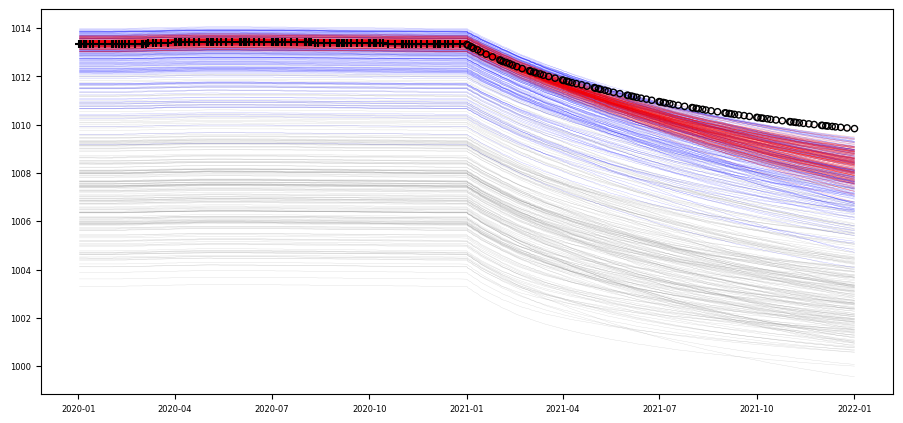

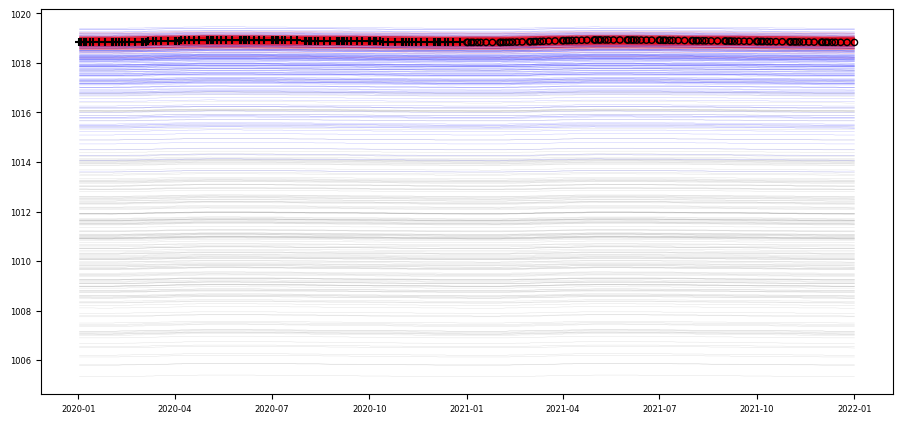

In [87]:
for i, g in pst.observation_data.groupby("obgnme"):
    f, ax = plt.subplots(1,1,figsize=(11,5), dpi=100)
    
    for n, clr in zip([0, 1, 2], ["0.5", "b", "r"]):
        for ii, rr in oe[n].iterrows():
            ax.plot(g.datetime, oe[n].loc[ii, g.obsnme], lw=0.25, c=clr, alpha=0.3)

    nz = g.loc[g["weight"]>0.]
    ax.scatter(nz["datetime"], nz["obsval"], marker="+", c="k", s=40, zorder=10)
    
    zw = g.loc[g["weight"]==0.]
    ax.scatter(zw["datetime"], zw["obsval"], marker="o", facecolor="None", edgecolor="k", s=20, zorder=10)

In [77]:
pe = {}
for n in [0, 1, 2]:
    pe[n] = pd.read_csv(os.path.join("master_pst1", "mumodel.{0}.par.csv".format(n)), index_col=0)

In [78]:
par = pst.parameter_data

In [79]:
par.pargp.unique()

array(['npf_cn', 'npf_pp', 'npf_gr', 'sto_cn', 'sto_pp', 'sto_gr',
       'rch_cn', 'rch_pp'], dtype=object)

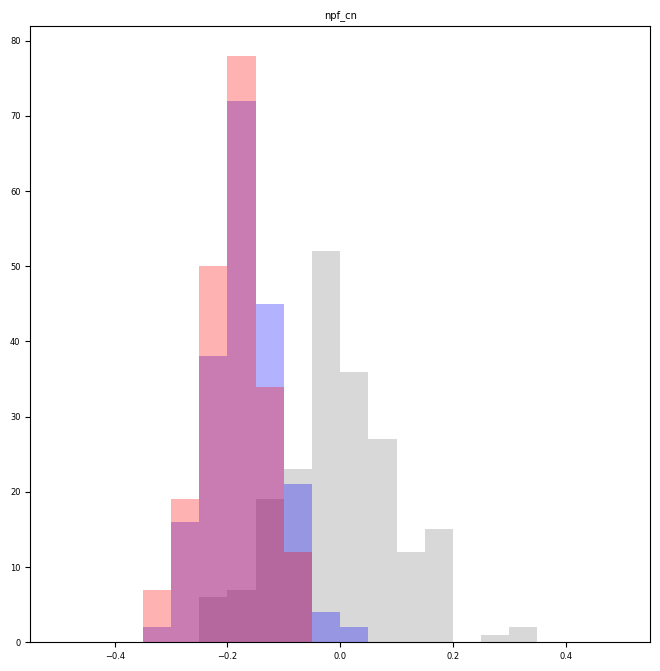

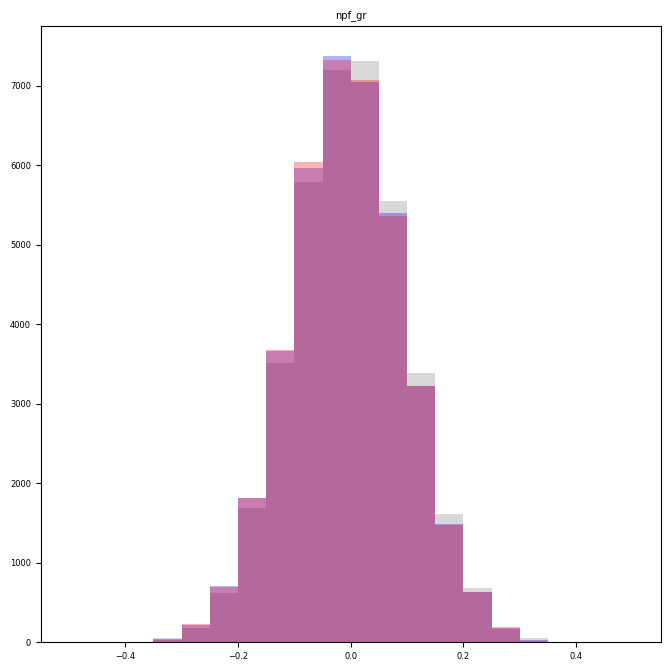

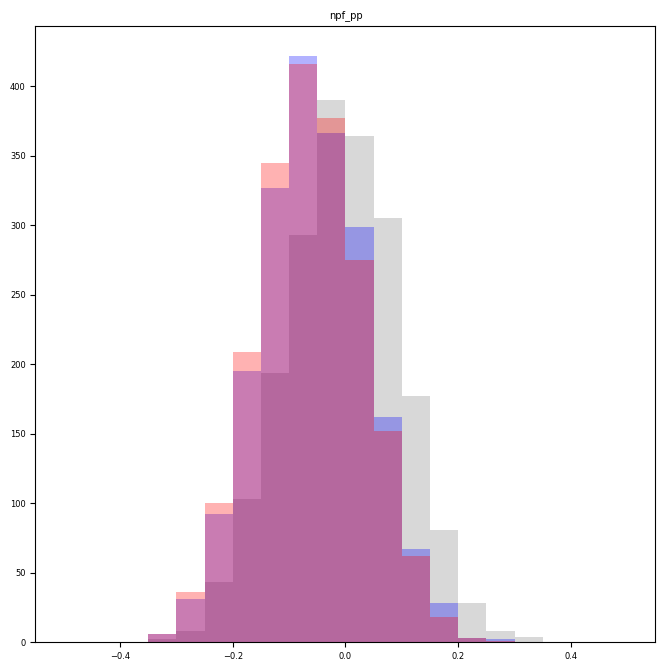

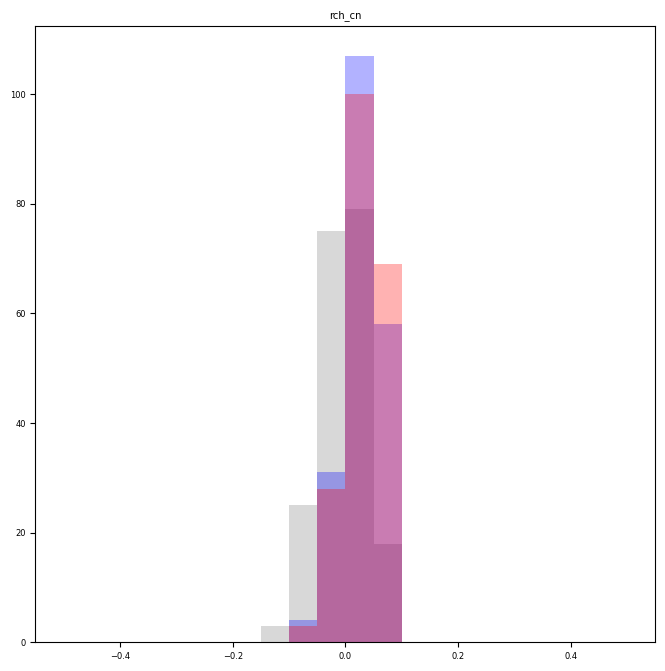

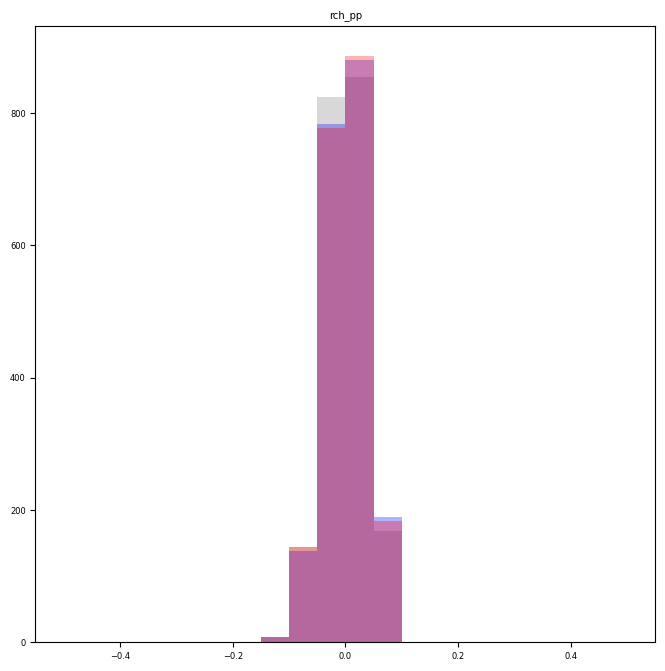

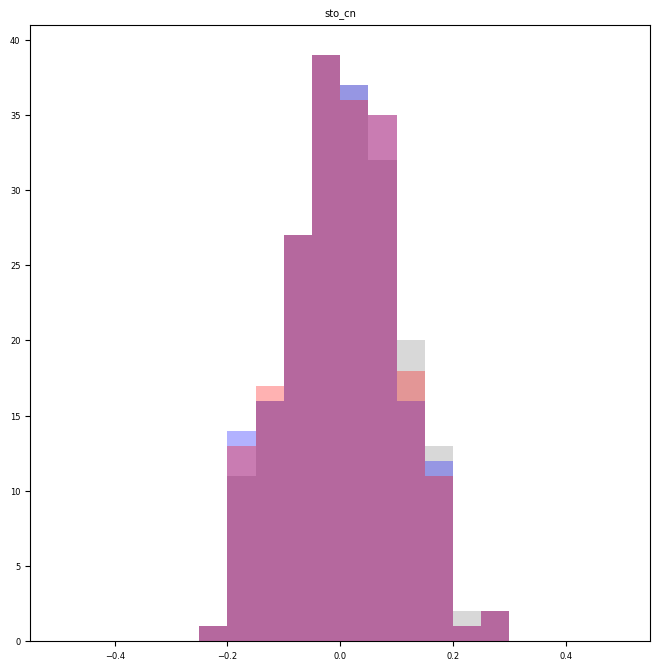

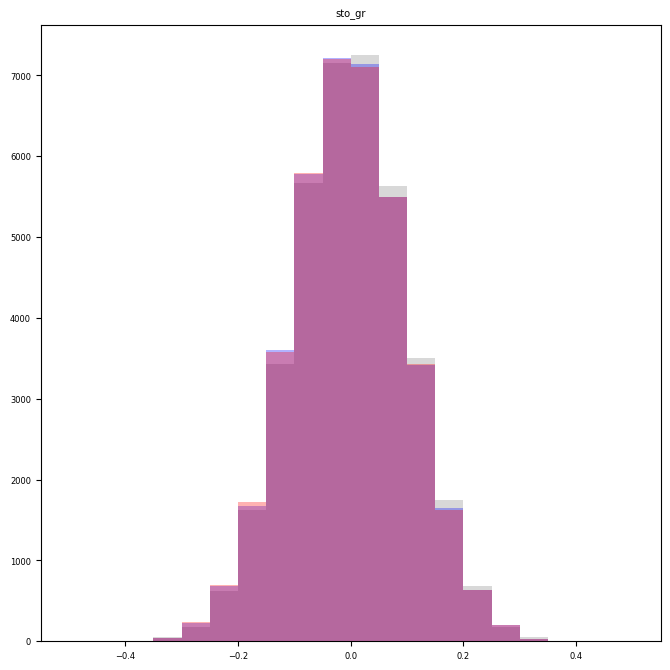

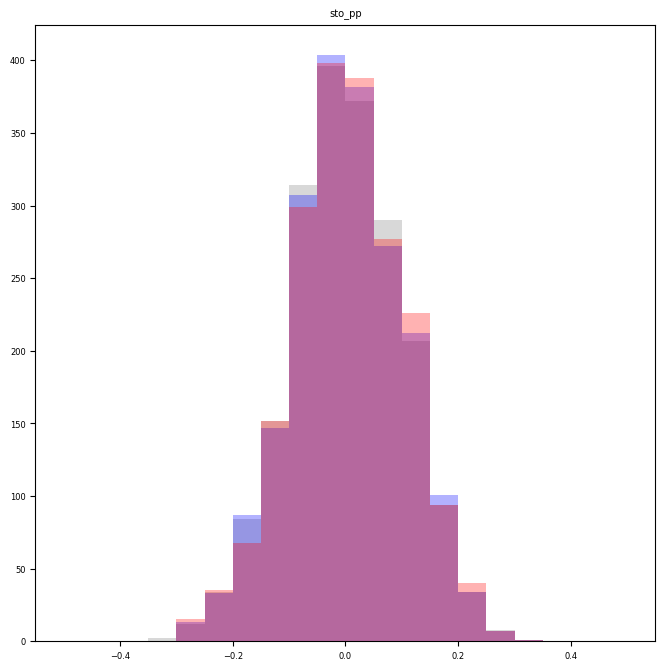

In [81]:
#for ix in par.loc[par["ptype"]=="cn"].index:
for i, g in par.groupby("pargp"):
    ix = g.parnme.values
    f, ax = plt.subplots(1,1,figsize=(8,8), dpi=100)

    for n, clr in zip([0, 1, 2], ["0.5", "b", "r"]):
        data = np.log10(pe[n].loc[:, ix].values.ravel())
        ax.hist(data, lw=0.25, facecolor=clr, alpha=0.3, bins=np.linspace(-0.5, 0.5, 21))
    ax.set_title(i)